# Setup

In [1]:
import pandas as pd
import numpy as np
import pickle
import torch
from tqdm import tqdm
from scipy.stats import entropy
from statsmodels.stats import multitest
from torch_geometric import seed_everything
import matplotlib.pyplot as plt
import plotly.express as px

import sys
sys.path.append("../../..")
from src.models import training_utils, final_model, prediction_utils

data_folder = "../../../data/processed/graph_data_nohubs/merged_types/split_dataset/"
feature_folder = "../../../data/processed/feature_data/"
reports_folder = "../../../reports/explore_predictions/"
models_folder = "../../../models/final_model/"

seed = 4
seed_everything(4)

Load data and model weights

In [2]:
#load data
dataset, node_map = training_utils.load_data(data_folder+f"seed_{seed}/",load_test=True)
test_data = dataset[2]
node_df = pd.read_csv(data_folder+f"seed_{seed}/tensor_df.csv",index_col=0).set_index("node_index",drop=True)

with open(f"{models_folder}training_parameters.pickle", 'rb') as handle:
    params = pickle.load(handle)

#initialize features in test data
test_data  = training_utils.initialize_features(test_data,params["feature_type"],params["feature_dim"],feature_folder)

#load model
weights_path = models_folder+f"seeds/final_model_{seed}.pth"
weights = torch.load(weights_path)
model = final_model.Model(test_data.metadata(),[("gene_protein","gda","disease")])
model.load_state_dict(weights)

<All keys matched successfully>

In [3]:
encodings_dict = training_utils.get_encodings(model,test_data)
mapped_dataset = prediction_utils.MappedDataset(test_data,node_map,("gene_protein","gda","disease"))
mapped_df = mapped_dataset.dataframe
predictor = prediction_utils.Predictor(node_df,encodings_dict)

diseases = node_df[node_df.node_type == "disease"].index.values
genes = node_df[node_df.node_type == "gene_protein"].index.values

saco los enlaces que ya existían en el grafo, que son los de propagación y las etiquetas positivas (básicamente disgenet)

In [4]:
remove_edges = mapped_df[(mapped_df.edge_type == "message_passing")| (mapped_df.label == 1)][["gene_protein","disease"]]

# Análisis de scores

## Enfermedades

Calcular la entropía y el disparity filter de los scores para cada nodo

Tengo valores que son 0, nose bien que hacer con esos

In [181]:
def get_entropy(arr, use_nonzero=False,max_norm=True):
    if use_nonzero:
        values = arr[np.nonzero(arr)]
    else:
        values = arr
    
    if max_norm:
        max_entropy = np.log2(len(values))
        S = entropy(values, base=2)/max_entropy
    else:
        S = entropy(values, base=2)

    return S

def disparity_filter(tensor):
    arr = tensor.numpy()
    has_zeros = any(arr == 0)
    nonzero = arr[np.nonzero(arr)]

    k = len(nonzero)
    sum_wij = np.sum(nonzero)
    normalized_scores = nonzero/sum_wij
    alpha_ij = (1 - normalized_scores)**(k-1)

    accepted = multitest.fdrcorrection(alpha_ij)[0]
    num_significativos = np.sum(accepted)
    score_significativos = arr[accepted]
    return num_significativos, score_significativos, has_zeros

In [261]:
disease_total_entropy = []
disease_mean_score_top50 = []
disease_mean_score_sig = []
disease_num_accepted = []
disease_has_zeros = []
disease_threshold = []

for disease in tqdm(diseases):
    if disease in remove_edges.disease.values:
        to_remove = remove_edges[remove_edges.disease == disease].gene_protein.values
        targets = node_df[node_df.node_type == "gene_protein"].drop(to_remove).index.values
        ranked_index, ranked_scores = predictor.prioritize_one_vs_all(disease,targets)
    else:
        ranked_index, ranked_scores = predictor.prioritize_one_vs_all(disease)

    disease_total_entropy.append(get_entropy(ranked_scores))
    disease_mean_score_top50.append(torch.mean(ranked_scores[:50]))
    num_acccepted, score_accepted, has_zeros = disparity_filter(ranked_scores)
    disease_num_accepted.append(num_acccepted)
    if num_acccepted != 0:
        disease_mean_score_sig.append(np.mean(score_accepted))
    else:
        disease_mean_score_sig.append(0)

    threshold_index = np.where(ranked_scores  < 0.5)[0][0]
    disease_threshold.append(threshold_index)

    disease_has_zeros.append(has_zeros)

100%|██████████| 16079/16079 [02:22<00:00, 112.79it/s]


In [413]:
disease_results = pd.DataFrame(np.array([disease_total_entropy,disease_mean_score_top50,disease_num_accepted,disease_mean_score_sig,disease_threshold, disease_has_zeros]).T,columns=["total_entropy","mean_score_top_50","num_significativos","mean_score_significativos","threshold_index","has_zeros"],index=diseases)
disease_results = pd.merge(disease_results, node_df[["node_name","degree_gda","total_degree"]],left_index=True,right_index=True)

In [5]:
# disease_results.drop(columns=["has_zeros"]).to_csv(reports_folder+"ranking_analysis/disease_report.csv")
disease_results = pd.read_csv(reports_folder+"ranking_analysis/disease_report.csv",index_col=0)
gene_results = pd.read_csv(reports_folder+"ranking_analysis/gene_report.csv",index_col=0)
disease_results

,total_entropy,mean_score_top_50,num_significativos,mean_score_significativos,threshold_index,node_name,degree_gda,total_degree
19599,0.977149,0.916945,0.0,0.0,9907.0,Hepatomegaly,54.0,54.0
20754,0.992168,0.981239,0.0,0.0,14017.0,Schizophrenia,883.0,884.0
24165,0.987018,0.984857,0.0,0.0,12882.0,Malignant neoplasm of prostate,616.0,622.0
18773,0.983836,0.974946,0.0,0.0,11625.0,Malignant neoplasm of breast,1074.0,1081.0
18732,0.977066,0.972474,0.0,0.0,9767.0,Bladder Neoplasm,140.0,145.0
...,...,...,...,...,...,...,...,...
30820,0.964498,0.942666,0.0,0.0,3005.0,"AMYLOID CARDIOMYOPATHY, TRANSTHYRETIN-RELATED",0.0,1.0
30959,0.974569,0.975511,0.0,0.0,10819.0,"BERNARD-SOULIER SYNDROME, TYPE A1",0.0,1.0
33955,0.990378,0.979014,0.0,0.0,13861.0,Triple-Negative Breast Carcinoma,0.0,1.0
32968,0.973991,0.959709,0.0,0.0,10356.0,DOCK8 Deficiency,0.0,1.0


In [263]:
disease_results.describe()

,entropy,mean_top_50,num_sig,mean_sig,threshold_index,has_zeros
count,16079.000000,16079.000000,16079.000000,16079.000000,16079.000000,16079.0
mean,0.937026,0.921773,161.796318,0.166151,4585.621369,0.0
std,0.049945,0.077861,300.573011,0.289655,4580.837480,0.0
min,0.623241,0.205870,0.000000,0.000000,0.000000,0.0
25%,0.915161,0.899984,0.000000,0.000000,661.500000,0.0
50%,0.948956,0.942694,0.000000,0.000000,1971.000000,0.0
75%,0.974707,0.969728,152.000000,0.366164,9237.500000,0.0
max,0.997931,0.999849,1104.000000,0.999068,16169.000000,0.0


In [264]:
disease_results[disease_results.num_sig != 0]

,entropy,mean_top_50,num_sig,mean_sig,threshold_index,has_zeros
19130,0.902607,0.983192,389.0,0.837672,860.0,0.0
21218,0.878501,0.960775,737.0,0.644715,585.0,0.0
20246,0.904938,0.979803,206.0,0.890773,799.0,0.0
19670,0.877383,0.940276,857.0,0.655105,688.0,0.0
21909,0.863411,0.949183,926.0,0.653821,691.0,0.0
...,...,...,...,...,...,...
22544,0.906811,0.922398,431.0,0.688577,459.0,0.0
27065,0.871220,0.990169,881.0,0.702847,753.0,0.0
26345,0.897890,0.972529,719.0,0.747807,844.0,0.0
25822,0.889459,0.966651,749.0,0.706748,687.0,0.0


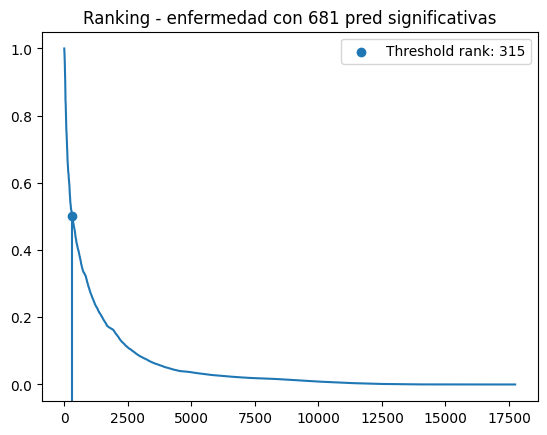

23905

In [63]:
index = disease_results[disease_results.num_significativos != 0].sample(1).index[0]
scores = predictor.prioritize_one_vs_all(index)
tensor = scores[1]
threshold_x = np.where(tensor  < 0.5)[0][0]

plt.figure()
plt.plot(range(len(tensor)),tensor)
plt.axvline(threshold_x, ymax=0.5)
plt.scatter(threshold_x,0.5,label=f"Threshold rank: {threshold_x}")
plt.title(f"Ranking - enfermedad con {disease_results.loc[index].num_significativos.astype(int)} pred significativas")
plt.legend()
plt.show()

index

In [12]:
disease_results.loc[index]

total_entropy                                    0.897468
mean_score_top_50                                0.632436
num_significativos                                  600.0
mean_score_significativos                        0.441058
threshold_index                                     183.0
node_name                    Osteitis Fibrosa Disseminata
degree_gda                                            2.0
total_degree                                          2.0
Name: 19362, dtype: object

In [278]:
disease_results[disease_results.num_sig == 0]

,entropy,mean_top_50,num_sig,mean_sig,threshold_index,has_zeros
19599,0.977149,0.916945,0.0,0.0,9907.0,0.0
20754,0.992168,0.981239,0.0,0.0,14017.0,0.0
24165,0.987018,0.984857,0.0,0.0,12882.0,0.0
18773,0.983836,0.974946,0.0,0.0,11625.0,0.0
18732,0.977066,0.972474,0.0,0.0,9767.0,0.0
...,...,...,...,...,...,...
30820,0.964498,0.942666,0.0,0.0,3005.0,0.0
30959,0.974569,0.975511,0.0,0.0,10819.0,0.0
33955,0.990378,0.979014,0.0,0.0,13861.0,0.0
32968,0.973991,0.959709,0.0,0.0,10356.0,0.0


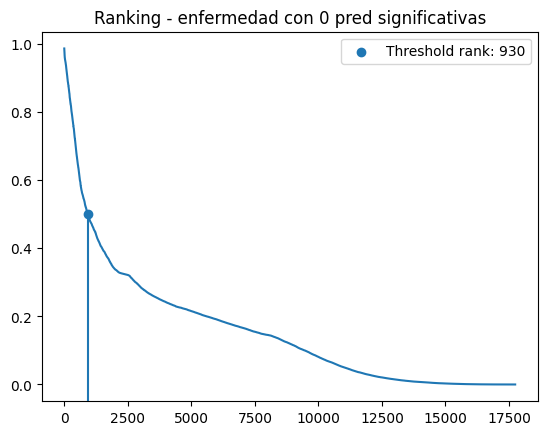

In [301]:
index = disease_results[disease_results.num_sig == 0].sample(1).index[0]
scores = predictor.prioritize_one_vs_all(index)
tensor = scores[1]
threshold_x = np.where(tensor  < 0.5)[0][0]

plt.figure()
plt.plot(range(len(tensor)),tensor)
plt.axvline(threshold_x, ymax=0.5)
plt.scatter(threshold_x,0.5,label=f"Threshold rank: {threshold_x}")
plt.title(f"Ranking - enfermedad con {disease_results.loc[index].num_sig.astype(int)} pred significativas")
plt.legend()
plt.show()

## Genes

In [266]:
gene_total_entropy = []
gene_mean_score_top50 = []
gene_mean_score_sig = []
gene_num_accepted = []
gene_has_zeros = []
gene_threshold = []

for gene in tqdm(genes):
    if gene in remove_edges.gene_protein.values:
        to_remove = remove_edges[remove_edges.gene_protein == gene].disease.values
        targets = node_df[node_df.node_type == "disease"].drop(to_remove).index.values
        ranked_index, ranked_scores = predictor.prioritize_one_vs_all(gene,targets)
    else:
        ranked_index, ranked_scores = predictor.prioritize_one_vs_all(gene)

    gene_total_entropy.append(get_entropy(ranked_scores))
    gene_mean_score_top50.append(torch.mean(ranked_scores[:50]))
    num_acccepted, score_accepted, has_zeros = disparity_filter(ranked_scores)
    gene_num_accepted.append(num_acccepted)
    if num_acccepted != 0:
        gene_mean_score_sig.append(np.mean(score_accepted))
    else:
        gene_mean_score_sig.append(0)

    threshold_index = np.where(ranked_scores  < 0.5)[0][0]
    gene_threshold.append(threshold_index)

    gene_has_zeros.append(has_zeros)

100%|██████████| 17743/17743 [02:04<00:00, 142.88it/s]


In [392]:
gene_results = pd.DataFrame(np.array([gene_total_entropy,gene_mean_score_top50,gene_num_accepted,gene_mean_score_sig,gene_threshold, gene_has_zeros]).T,columns=["total_entropy","mean_score_top_50","num_signigicativos","mean_score_significativos","threshold_index","has_zeros"],index=genes)
gene_results = pd.merge(gene_results, node_df[["node_name","degree_gda","total_degree"]],left_index=True,right_index=True)
gene_results

,total_entropy,mean_score_top_50,num_signigicativos,mean_score_significativos,threshold_index,has_zeros,node_name,degree_gda,total_degree
0,0.888022,0.890528,0.0,0.000000,1082.0,0.0,A1BG,2.0,14.0
653,0.976510,0.932913,0.0,0.000000,7243.0,0.0,UBAC1,0.0,36.0
13168,0.863455,0.959170,741.0,0.705798,841.0,0.0,RNF123,2.0,26.0
6638,0.919731,0.987304,0.0,0.000000,3253.0,0.0,WDR62,14.0,32.0
6611,0.973985,0.957985,0.0,0.000000,6859.0,0.0,GDPD1,0.0,29.0
...,...,...,...,...,...,...,...,...,...
18384,0.908027,0.968472,0.0,0.000000,1748.0,0.0,HS3ST4,3.0,4.0
18386,0.977956,0.917929,0.0,0.000000,6774.0,0.0,HS3ST3A1,0.0,1.0
18388,0.977957,0.917377,0.0,0.000000,6767.0,0.0,HS3ST1,0.0,1.0
18395,0.880132,0.940720,0.0,0.000000,1151.0,0.0,SLC23A2,1.0,2.0


In [395]:
gene_results.drop(columns=["has_zeros"]).to_csv(reports_folder+"ranking_analysis/gene_report.csv")

In [271]:
gene_results.describe()

,entropy,mean_top_50,num_sig,mean_sig,threshold_index,has_zeros
count,17743.000000,17743.000000,17743.000000,17743.000000,17743.000000,17743.0
mean,0.933726,0.947207,61.087922,0.064404,4155.565913,0.0
std,0.036308,0.043868,207.486722,0.210035,2323.410829,0.0
min,0.749718,0.480672,0.000000,0.000000,8.000000,0.0
25%,0.905912,0.934337,0.000000,0.000000,1989.000000,0.0
50%,0.943581,0.959888,0.000000,0.000000,4187.000000,0.0
75%,0.964556,0.972199,0.000000,0.000000,6114.000000,0.0
max,0.997739,0.999936,1369.000000,0.974874,13640.000000,0.0


In [272]:
gene_results[gene_results.mean_sig != 0]

,entropy,mean_top_50,num_sig,mean_sig,threshold_index,has_zeros
13168,0.863455,0.959170,741.0,0.705798,841.0,0.0
6896,0.888574,0.972447,284.0,0.816846,706.0,0.0
15674,0.851631,0.987969,934.0,0.760191,1062.0,0.0
10682,0.879676,0.940381,269.0,0.794530,849.0,0.0
17035,0.877924,0.878679,474.0,0.645262,466.0,0.0
...,...,...,...,...,...,...
18168,0.855557,0.998395,879.0,0.788638,977.0,0.0
18232,0.866888,0.938737,742.0,0.761891,1157.0,0.0
18282,0.868176,0.793689,523.0,0.605022,450.0,0.0
18316,0.859030,0.954602,766.0,0.694214,776.0,0.0


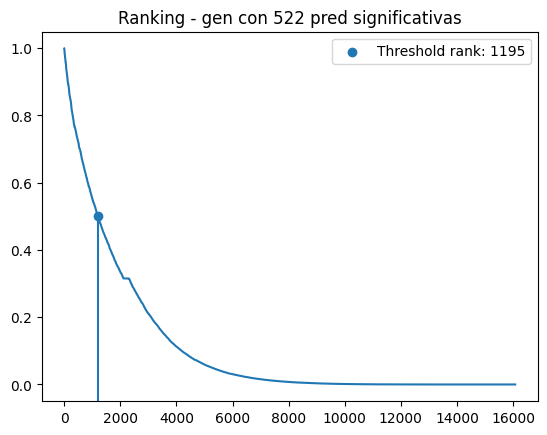

In [303]:
index = gene_results[gene_results.num_sig != 0].sample(1).index[0]
scores = predictor.prioritize_one_vs_all(index)
tensor = scores[1]
threshold_x = np.where(tensor  < 0.5)[0][0]

plt.figure()
plt.plot(range(len(tensor)),tensor)
plt.axvline(threshold_x, ymax=0.5)
plt.scatter(threshold_x,0.5,label=f"Threshold rank: {threshold_x}")
plt.title(f"Ranking - gen con {gene_results.loc[index].num_sig.astype(int)} pred significativas")
plt.legend()
plt.show()

In [20]:
gene_results

,total_entropy,mean_score_top_50,num_signigicativos,mean_score_significativos,threshold_index,node_name,degree_gda,total_degree
0,0.888022,0.890528,0.0,0.000000,1082.0,A1BG,2.0,14.0
653,0.976510,0.932913,0.0,0.000000,7243.0,UBAC1,0.0,36.0
13168,0.863455,0.959170,741.0,0.705798,841.0,RNF123,2.0,26.0
6638,0.919731,0.987304,0.0,0.000000,3253.0,WDR62,14.0,32.0
6611,0.973985,0.957985,0.0,0.000000,6859.0,GDPD1,0.0,29.0
...,...,...,...,...,...,...,...,...
18384,0.908027,0.968472,0.0,0.000000,1748.0,HS3ST4,3.0,4.0
18386,0.977956,0.917929,0.0,0.000000,6774.0,HS3ST3A1,0.0,1.0
18388,0.977957,0.917377,0.0,0.000000,6767.0,HS3ST1,0.0,1.0
18395,0.880132,0.940720,0.0,0.000000,1151.0,SLC23A2,1.0,2.0


In [28]:
node_df.loc[3958]

node_id                        1956
node_name                      EGFR
node_type              gene_protein
node_source                disgenet
tensor_index                    329
comunidades_infomap             NaN
comunidades_louvain             NaN
degree_gda                    124.0
degree_pp                     430.0
degree_dd                       0.0
total_degree                  554.0
Name: 3958, dtype: object

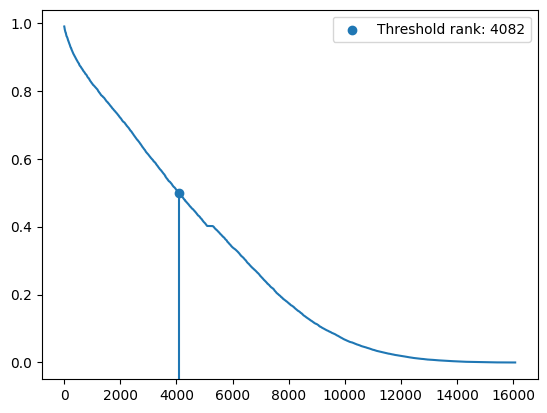

In [27]:
# index = gene_results[gene_results.num_sig == 0].sample(1).index[0]
index = 3958
scores = predictor.prioritize_one_vs_all(index)
tensor = scores[1]
threshold_x = np.where(tensor  < 0.5)[0][0]

plt.figure()
plt.plot(range(len(tensor)),tensor)
plt.axvline(threshold_x, ymax=0.5)
plt.scatter(threshold_x,0.5,label=f"Threshold rank: {threshold_x}")
# plt.title(f"Ranking - gen con {gene_results.loc[index]["num_significativos"].astype(int)} pred significativas")
plt.legend()
plt.show()

# Significativas en función del grado

In [30]:
diseases_merged = pd.merge(disease_results, node_df[["degree_gda","total_degree"]],left_index=True,right_index=True)
genes_merged = pd.merge(gene_results,node_df[["degree_gda","total_degree"]],left_index=True,right_index=True)

In [36]:
fig = px.scatter(diseases_merged,x="degree_gda_x",y="num_significativos",log_x=True)
fig.show()

In [366]:
fig = px.scatter(genes_merged.reset_index(),x="total_degree",y="num_sig",text="index")
fig.show()

Bueno, por lo menos no es que generó asociaciones significativas sólo para los nodos de grado alto, al contrario. El número de asociaciones significativas encontradas no parece depender del grado (gda o total) del nodo.

La entropía no funcionó como medida de homogeneidad (me parece), porque vi algunos ejemplos con entropía alta que en realidad son una buena curva, habría que ver otra medida.

In [26]:
node_df.loc[9316]

node_id                        4609
node_name                       MYC
node_type              gene_protein
node_source                disgenet
tensor_index                   1077
comunidades_infomap             NaN
comunidades_louvain             NaN
degree_gda                     91.0
degree_pp                     610.0
degree_dd                       0.0
total_degree                  701.0
Name: 9316, dtype: object

In [345]:
genes_merged[genes_merged.total_degree == 4].sort_values(by="num_sig")

,entropy,mean_top_50,num_sig,mean_sig,threshold_index,has_zeros,degree_gda,total_degree
7000,0.891931,0.938158,0.0,0.000000,1475.0,0.0,1.0,4.0
10999,0.959925,0.978482,0.0,0.000000,6146.0,0.0,0.0,4.0
9682,0.964700,0.968434,0.0,0.000000,6310.0,0.0,0.0,4.0
17435,0.967156,0.974211,0.0,0.000000,6749.0,0.0,0.0,4.0
6651,0.968494,0.923236,0.0,0.000000,6281.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...
5281,0.820640,0.916172,1013.0,0.578420,618.0,0.0,2.0,4.0
17551,0.847115,0.965518,1021.0,0.729513,1079.0,0.0,2.0,4.0
2745,0.820851,0.999479,1087.0,0.703564,914.0,0.0,4.0,4.0
2758,0.816312,0.999742,1107.0,0.719147,952.0,0.0,3.0,4.0


In [377]:
index = 11189
node_df.loc[index]

node_id                       55154
node_name                     MSTO1
node_type              gene_protein
node_source                disgenet
tensor_index                   8589
comunidades_infomap             NaN
comunidades_louvain             NaN
degree_gda                      1.0
degree_pp                      10.0
degree_dd                       0.0
total_degree                   11.0
Name: 11189, dtype: object

In [17]:
rankings = pd.read_csv("../../../reports/model_predictions/disease_predictions.csv",index_col=0)

In [382]:
disgenet_diseases = mapped_df[(mapped_df.gene_protein == index) & (mapped_df.label != 0)].disease.values
node_df.loc[disgenet_diseases]

,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
33501,C4540096,"MYOPATHY, MITOCHONDRIAL, AND ATAXIA",disease,disgenet,12080,406.0,51.0,1.0,0.0,1.0,2.0


In [379]:
candidatas = rankings.loc[index].values
node_df.loc[candidatas]

,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
31872,C3809216,MUSCULAR DYSTROPHY-DYSTROGLYCANOPATHY (CONGENI...,disease,disgenet,5472,851.0,25.0,1.0,0.0,1.0,2.0
32342,C4015108,Episodic ataxia with slurred speech,disease,disgenet,3409,972.0,136.0,1.0,0.0,1.0,2.0
29836,C2680446,"SPASTIC PARAPLEGIA 43, AUTOSOMAL RECESSIVE",disease,disgenet,5881,379.0,37.0,1.0,0.0,1.0,2.0
28291,C1853249,SPINOCEREBELLAR ATAXIA 28,disease,disgenet,2248,663.0,53.0,1.0,0.0,1.0,2.0
30824,C3151519,MUSCULAR DYSTROPHY-DYSTROGLYCANOPATHY (CONGENI...,disease,disgenet,5474,851.0,25.0,1.0,0.0,1.0,2.0
30581,C3150411,MUSCULAR DYSTROPHY-DYSTROGLYCANOPATHY (CONGENI...,disease,disgenet,5475,851.0,25.0,1.0,0.0,1.0,2.0
31441,C3553330,MUSCULAR DYSTROPHY-DYSTROGLYCANOPATHY (CONGENI...,disease,disgenet,5479,851.0,25.0,1.0,0.0,1.0,2.0
32727,C4225291,MUSCULAR DYSTROPHY-DYSTROGLYCANOPATHY (CONGENI...,disease,disgenet,5477,851.0,25.0,1.0,0.0,1.0,2.0
30582,C3150412,MUSCULAR DYSTROPHY-DYSTROGLYCANOPATHY (CONGENI...,disease,disgenet,4847,900.0,25.0,1.0,0.0,1.0,2.0


10451 = PHKA1 -> (en disgenet) está asociado a "glycogen storage diseases", me recomienda otro montón de enfermedades relacionadas con glycogen storage

4078 = IBA57 -> (en disgenet) está asociado a desordenes de mitocondria y "spastic paraplegia", me recomienda cosas de mitocondria, fosforilación y "encephalopaty" -> de esto último encontré algo en google

10129 = UBR5 -> (en disgenet) está asoaciado a enfermedades del estómago -> me recomienda más enfermedades "gástricas" y un tipo de anemia

# Generar recomendaciones significativas

Dado un índice generar el df de recomendaciones

In [18]:
index = 19362
asociaciones_disgenet = mapped_df[(mapped_df.disease == index) & (mapped_df.label != 0)].gene_protein.values
display(node_df.loc[index])
display(node_df.loc[asociaciones_disgenet])
candidatos = rankings.loc[index].values
node_df.loc[candidatos]

node_id                                    C0016063
node_name              Osteitis Fibrosa Disseminata
node_type                                   disease
node_source                                disgenet
tensor_index                                   8953
comunidades_infomap                             NaN
comunidades_louvain                             NaN
degree_gda                                      2.0
degree_pp                                       0.0
degree_dd                                       0.0
total_degree                                    2.0
Name: 19362, dtype: object

,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
9300,4591,TRIM37,gene_protein,disgenet,206,NaN,NaN,8.0,45.0,0.0,53.0
5229,2353,FOS,gene_protein,disgenet,2999,NaN,NaN,104.0,81.0,0.0,185.0


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
6420,2760,GM2A,gene_protein,disgenet,3572,NaN,NaN,3.0,19.0,0.0,22.0
18131,9693,RAPGEF2,gene_protein,disgenet,4195,NaN,NaN,10.0,10.0,0.0,20.0
13114,6335,SCN9A,gene_protein,disgenet,16661,NaN,NaN,42.0,2.0,0.0,44.0
12792,5981,RFC1,gene_protein,disgenet,8785,NaN,NaN,14.0,56.0,0.0,70.0
7167,3073,HEXA,gene_protein,disgenet,6516,NaN,NaN,10.0,9.0,0.0,19.0
15846,8218,CLTCL1,gene_protein,disgenet,3755,NaN,NaN,1.0,41.0,0.0,42.0
17322,90678,LRSAM1,gene_protein,disgenet,16953,NaN,NaN,9.0,8.0,0.0,17.0
14082,6904,TBCD,gene_protein,disgenet,11576,NaN,NaN,54.0,12.0,0.0,66.0
3374,1583,CYP11A1,gene_protein,disgenet,10631,NaN,NaN,37.0,5.0,0.0,42.0
